<h1 style="background-color:#7bccc4;"></br><center>Will Drive For Coupons</br></h1>

## Do drivers change their plans when they are offered a short-lived coupon on their smartphone ? Do they accept the coupon ? How do the weather, the direction they're heading, how frequently they visit bars, their income group relate to their decision ? This project aims to determine factors that lead to accurate predictions for such situations. 



### Executive Summary

    - Acquire & prepare
    - Split and explore
    - Models — create, compare & decide
    - Conclusion and summary




### Data Acquisition

    - Data was obtained as a .cvs file from the UCI Machine Learning Repository. 
    - The newly acquired dataframe represented 12684 rows and 26 columns.
    - Each row represented a different driver response.
    - Each column represented a different feature of the driver, ranging from income group to educational level to martial status to how far the driver was from the location of the proposed coupon to which direction the driver was driving.

### Data Preparation

    - To prepare the data, it was necessary to drop unnecessary columns.
    - The categorical columns were encoded, with dummy variables being created. The dummy variables were then concatenated onto the prepared wine dataframe.
    - Null values, being an insignificant percentage of the overall data and mostly being found in features not being explored, were dropped.
    - Features specifically examined were
        (1) relationship between the weather and the coupon being accepted,
        (2) whether people heading in the opposite direction of the coupon offer were more likely to accept the             coupon than people heading in the same direction as the coupon,
        (3) whether there was a relationship between income group and accepting the coupon and
        (4) how frequency of visiting a bar related to accepting the coupon.
    These were analysed against the target variable of accepting the coupon.



In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import scipy as sc

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import LassoLars

from scipy import stats
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.cluster import KMeans

from sklearn.feature_selection import SelectKBest, f_regression, RFE

# from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier

# import my functions
import env
import prepare_xy_split as p
import selectKBest_rfe_functions as s
import fonctions as c
import wrangle

# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

<h1 style="background-color:#7bccc4;"></br><center>Acquisition</br></h1>

In [2]:
# acquire

coup = pd.read_csv('in-vehicle-coupon-recommendation.csv')

In [3]:
coup.shape

(12684, 26)

In [4]:
# look at data

coup.sample(3)

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
7474,Home,Alone,Snowy,30,10PM,Restaurant(20-50),2h,Female,31,Unmarried partner,...,never,less1,less1,never,1,0,0,0,1,1
10789,Home,Alone,Snowy,30,10PM,Carry out & Take away,1d,Female,31,Single,...,1~3,1~3,1~3,less1,1,1,1,0,1,1
7945,Work,Alone,Snowy,30,7AM,Restaurant(<20),2h,Female,26,Single,...,less1,1~3,gt8,gt8,1,1,1,0,1,1


In [5]:
# look at nulls

coup.isna().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

<h2 style="background-color:#c7e9c0;"></br><center>Cleaning</br></h2>

**All columns appear to have appropriate dtypes.**

In [6]:
# dropping columns

coup = coup.drop(columns = ['destination', 'passanger', 'time','temperature', 'coupon', 
                            'expiration', 'gender', 'age', 'maritalStatus', 'CoffeeHouse',
                            'toCoupon_GEQ5min','toCoupon_GEQ15min', 'toCoupon_GEQ25min',
                            'has_children', 'education', 'occupation', 'car',
                            'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50'])

In [7]:
# renaming 

coup = coup.rename(columns = {'Bar' : 'bar', 'direction_same' : 'dir_same', 'direction_opp': 'dir_opp'})

**Dropping car column due to prevalence of null values.**   

**Dropping 'age', 'destination', 'passanger', 'expiration', 'gender', 'marital_status', 'resto_less_than_20', 'resto_20_50', 'to_coupon_GEQ5m', 'to_coupon_GEQ15m', 'to_coupon_GEQ25m' because they will not be examined.**

In [8]:
# dropping remaining nulls

coup = coup.dropna()

**The target will be 'Y' (1 = accepted coupon, 0 = did not accept coupon).**

In [9]:
# sorting by values

coup = coup.sort_values(['weather'], ascending = [True])

In [10]:
# making dummies

dummies = pd.get_dummies(coup[['weather', 'income', 'bar']])
coup = pd.concat([coup, dummies], axis = 1)

In [11]:
coup.sample()

,weather,income,bar,dir_same,dir_opp,Y,weather_Rainy,weather_Snowy,weather_Sunny,income_$100000 or More,...,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,bar_1~3,bar_4~8,bar_gt8,bar_less1,bar_never
11712,Sunny,$37500 - $49999,never,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
# renaming dummy columns

coup.rename(columns = {'income_$100000 or More':'income_100000_or_more',
                           'income_$12500 - $24999' : 'income_12500_24999',
                           'income_$25000 - $37499' : 'income_25000_37499',
                           'income_$37500 - $49999' : 'income_37500_49999',
                           'income_$50000 - $62499' : 'income_50000_62499',
                           'income_$62500 - $74999' : 'income_62500_74999',
                           'income_$75000 - $87499' : 'income_75000_87499',
                           'income_$87500 - $99999' : 'income_87500_99999',
                           'income_Less than $12500': 'income_less_than_12500'}, inplace = True)

In [13]:
# renaming dummy columns

coup.rename(columns = {'bar_1~3' : 'bar_1_3', 
                       'bar_4~8' : 'bar_4_8'}, inplace = True)

In [14]:
# converting uint to int

coup = s.to_integer(coup)


<h2 style="background-color:#c7e9c0;"></br><center>Initial Graphing</br></h2>

**Hypotheses:**  
1/ $H_{0}$ : There is no relationship between the weather and the coupon being accepted.  
$H_{a}$ : There is a relationship between the weather and the coupon being accepted.  

2/ $H_{0}$ : People heading in the opposite direction are equally likely to accept the coupon as people heading in the same direction as the coupon.  
$H_{a}$ : People heading in the opposite direction are more likely to accept the coupon than people heading in the same direction as the coupon.  

3/ $H_{0}$ : Income group has no relationship to accepting the coupon.  
$H_{a}$ : Income group has a relationship to accepting the coupon.  

4/ $H_{0}$ : There is no relationship between bar-visit frequency and accepting the coupon.  
$H_{a}$ : There is a relationship between bar-visit frequency and accepting the coupon.  




In [15]:
coup.head(1)

,weather,income,bar,dir_same,dir_opp,Y,weather_Rainy,weather_Snowy,weather_Sunny,income_100000_or_more,...,income_50000_62499,income_62500_74999,income_75000_87499,income_87500_99999,income_less_than_12500,bar_1_3,bar_4_8,bar_gt8,bar_less1,bar_never
9837,Rainy,$50000 - $62499,1~3,0,1,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0


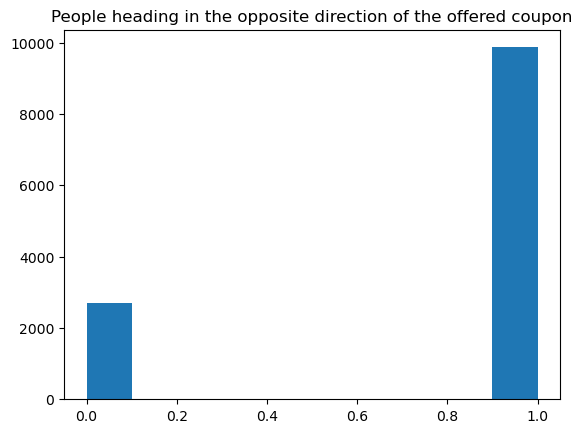

In [16]:
# plotting heading in the opposite direction

plt.hist(coup['dir_opp'])
plt.title('People heading in the opposite direction of the offered coupon')

# fig.set_xticklabels(['0',  '1']) # not working
# plt.legend(['0 = Heading Same Direction', '1 = Heading Opposite'])
plt.show()

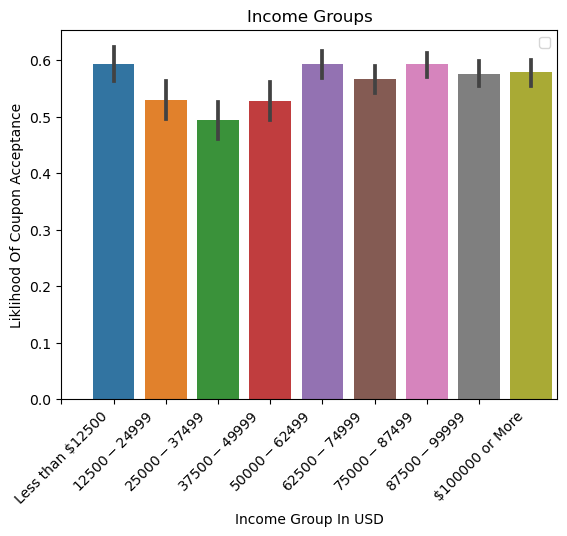

In [17]:
# plotting income

c.plot_income(coup)

**Income groups appear to have a slight bimodal distribution, with people in the income 75_000 to 87_499 USD range seeming to be the least likely group to accept the coupon.**

Text(0.5, 1.0, 'Bar visit frequency')

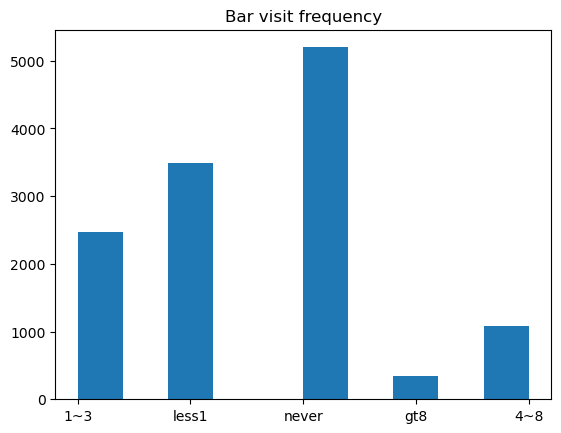

In [18]:
# plotting 'bar'

plt.hist(coup['bar'])
plt.title('Bar visit frequency')

**The majority of people in the dataset self-report as rarely, if ever, going to bars.**

Text(0.5, 1.0, 'Weather and the offered coupon')

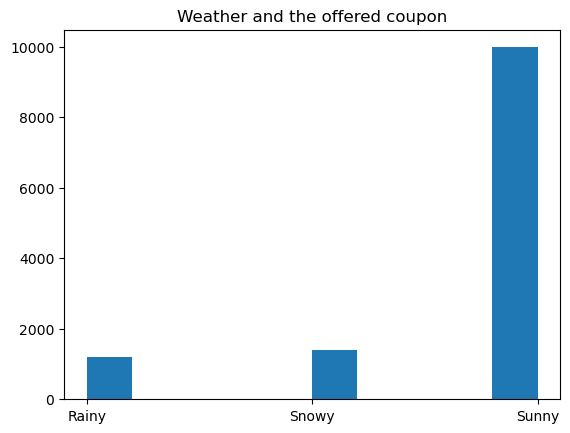

In [19]:
# plotting weather 

plt.hist(coup['weather'])
plt.title('Weather and the offered coupon')

**Sunny days prevail.**

## Splitting the data

In [20]:
# creating numeric column for the 3 weather types 

coup = c.weather3_col(coup)

In [21]:
# dropping weather, income, after initial visualisation

coup = coup.drop(columns = ['weather', 'income', 'bar'])

In [22]:
coup.columns

Index(['dir_same', 'dir_opp', 'Y', 'weather_Rainy', 'weather_Snowy',
       'weather_Sunny', 'income_100000_or_more', 'income_12500_24999',
       'income_25000_37499', 'income_37500_49999', 'income_50000_62499',
       'income_62500_74999', 'income_75000_87499', 'income_87500_99999',
       'income_less_than_12500', 'bar_1_3', 'bar_4_8', 'bar_gt8', 'bar_less1',
       'bar_never', 'weather3'],
      dtype='object')

In [23]:
coup = c.bar_freq_col(coup)

In [24]:
coup = c.income_col(coup)

In [25]:
# split 
train, val, test = p.train_val_test(coup, 'Y')

In [26]:
# dividing into Xs and ys 

X_train, y_train, X_val, y_val, X_test, y_test = p.tts_xy(train, val, test, 'Y')

&nbsp;

<h1 style="background-color:#7bccc4;"></br><center>Exploration</br></h1>

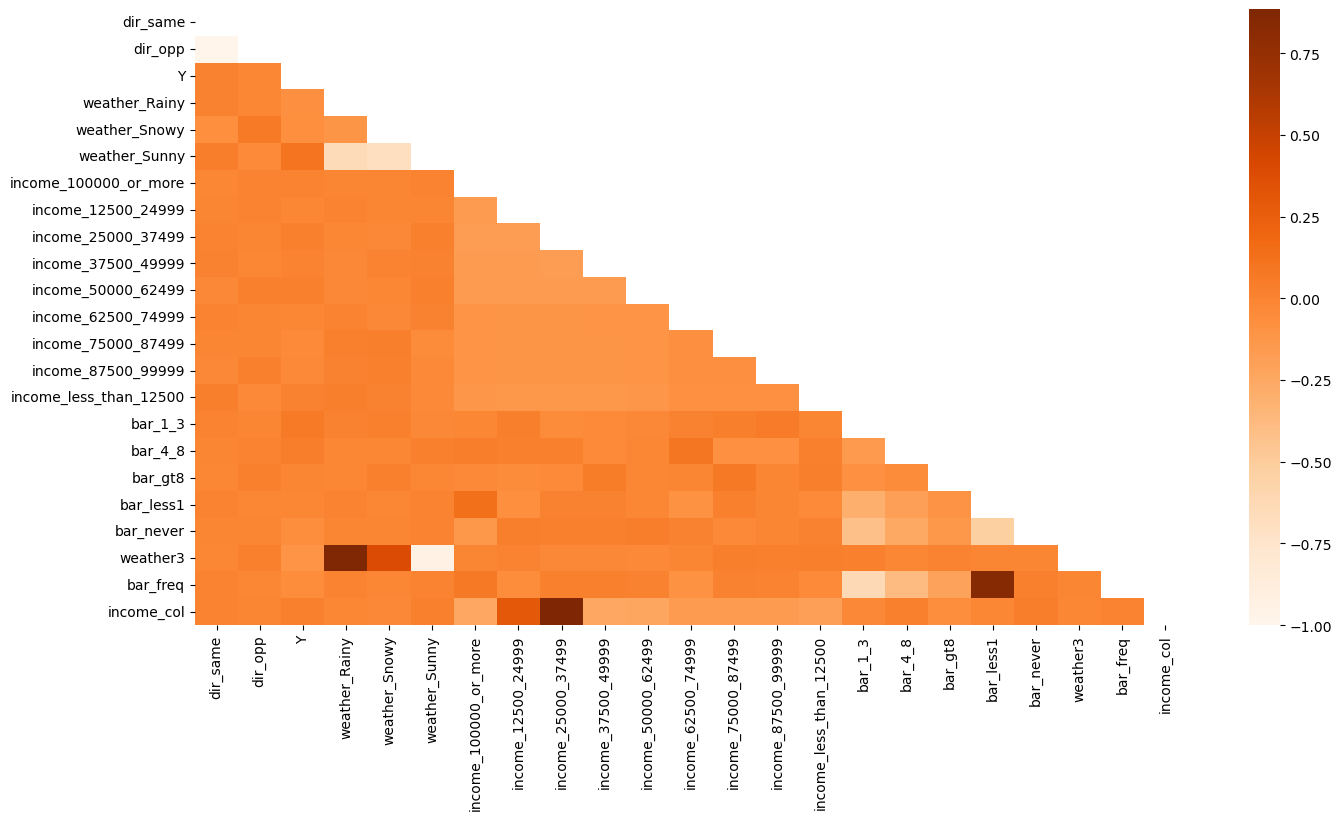

In [27]:
c.heat(train)

**In the heatmap, it can be seen that there is a correlation between the different types of weather and the temperature, which is logical, and normal, and will not be examined here.**  

**Overall, few of the numeric columns show highly significant correlation to the target variable ('Y'), or accepting the coupon.**  

&nbsp;

<h2 style="background-color:#c7e9c0;"></br><center>Questions To Explore</br></h2>

- Question 1 : Is there a relationship between the weather and the coupon being accepted ?  


- Question 2 : Are people heading in the opposite direction of the coupon offer more likely to accept the coupon than people heading in the same direction as the coupon ?  


- Question 3 : Is there a relationship between income group and accepting the coupon ?  


- Question 4 : Are different income groups more likely to accept the coupon ?



&nbsp;

### 1/ $H_{0}$ : There is no relationship between the weather and the coupon being accepted.  
### $H_{a}$ : There is a relationship between the weather and the coupon being accepted.  

In [28]:
# looking at values in each weather-dummy column

train['weather_Snowy'].sum(), train['weather_Sunny'].sum(), train['weather_Rainy'].sum(), 

(957, 7010, 836)

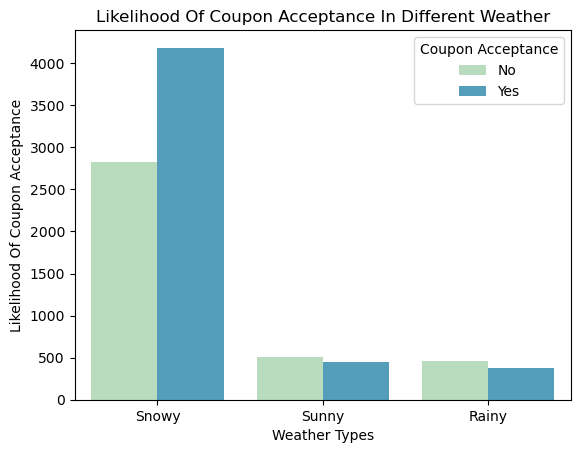

In [29]:
# plotting weather & coupon acceptance

c.plot_weather_coupon(train)

**The barplot would seem to indicate that people are most likely to accept the coupon during sunny weather, followed by snowy and then rainy weather. However, during snowy and rainy weather, people are slightly more likely to reject the coupon than to accept it.**

In [30]:
# t-test on weather & coupon acceptance

c.chi_sq(train['Y'], train['weather3'])

Chi-square  : 110.6920

P-value : 0.0000

We reject the null hypothesis ; there is a relationship between the target variable and the feature examined.


**TAKEAWAYS : The Chi-square and the barplot both show that there is a significant correlation between the type of weather and the likelihood of a person accepting the coupon.**

&nbsp;

### 2/ $H_{0}$ : People heading in the opposite direction are equally likely to accept the coupon as people heading in the same direction as the coupon.  
### $H_{a}$ : People heading in the opposite direction are more likely to accept the coupon than people heading in the same direction as the coupon.  

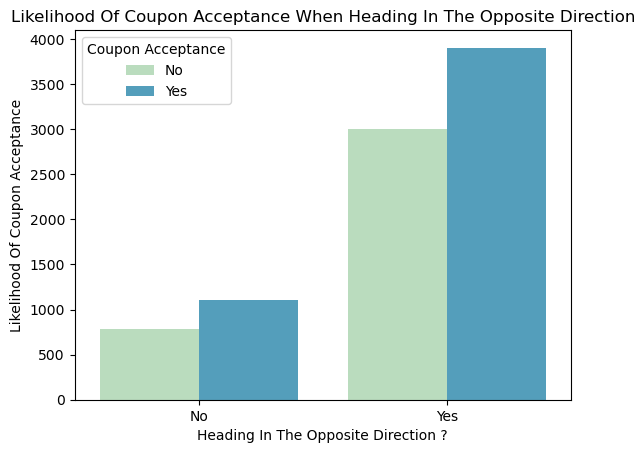

In [31]:
# plot direction

c.plot_opp_dir(train)

**Overall, it appears that of the people in the sample group, more people to whom were proposed coupons were heading in a direction opposite the location of the coupon offered. Likewise, the percentage of people who accepted the coupon was alsogreater in the group heading opposite the coupon offer.**

In [32]:
# chi-square test for opposite direction

c.chi_sq(train['Y'], train['dir_opp'])

Chi-square  : 1.9384

P-value : 0.1638

We fail to reject the null hypothesis.


**TAKEAWAYS : As seen in the barplot and from the Chi-square test, there is a mild relationship between people heading in the opposite direction of the offered coupon, and them accepting said coupon.**

&nbsp;

### 3/ $H_{0}$ : Income group has no relationship to accepting the coupon.  
### $H_{a}$ : Income group has a relationship to accepting the coupon.  

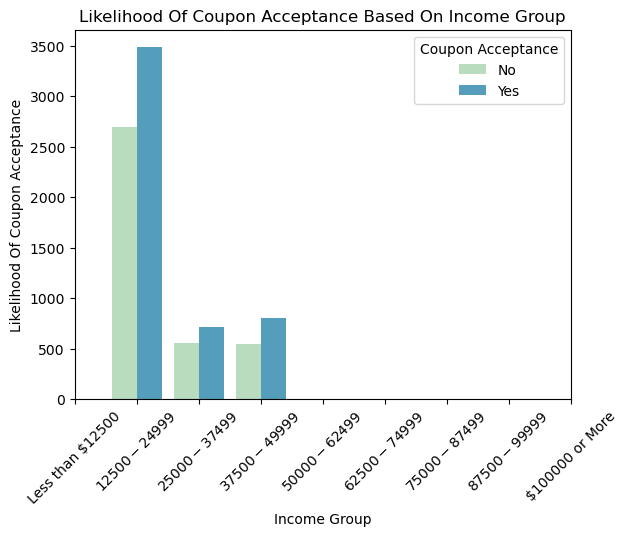

In [33]:
# plotting income groups and coupon acceptance

c.plot_explore_inc(train)

**Income groups are all over the place, with a potentially bimodal distribution at best. Acceptance of the offered coupon differed significantly amongst income brackets, with no real visual alignment of income group and coupon acceptance.**

In [34]:
# chi-square test for income groups

c.chi_sq(train['Y'], train['income_col'])

Chi-square  : 5.7381

P-value : 0.0568

We reject the null hypothesis ; there is a relationship between the target variable and the feature examined.


**TAKEAWAYS : There is a notable relationship between income group and aceepting the coupon, as seen by the Chi-square test and as visualised in the barplot.**

&nbsp;


### 4/ $H_{0}$ : There is no relationship between bar-visit frequency and accepting the coupon.  
### $H_{a}$ : There is a relationship between bar-visit frequency and accepting the coupon.  



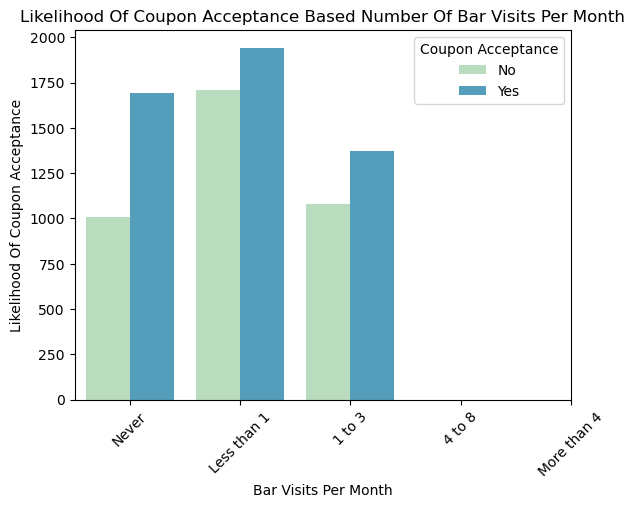

In [35]:
c.plot_explore_bar(train)

**The barplot indicates that people who frequent a bar from 1 to 3 times a month comprise the largest single group (in relation to bar visits) in the targetted population. Regardless of number of bar visits per month, all groups appear to have more people who accept the proposed coupon than who reject it.**

In [36]:
# chi-square test for bar visit frequency

c.chi_sq(train['Y'], train['bar_freq'])

Chi-square  : 58.1877

P-value : 0.0000

We reject the null hypothesis ; there is a relationship between the target variable and the feature examined.


**TAKEAWAYS : Both the Chi-square statistic and the barplot indicate that there is a relationship between number of bar visits per month and accepting the coupon.**

### Exploration Takeaways

**All features explored — weather, direction heading at time of coupon offer, income group, number of bar visits per month — have a positive relationship to the target variable of accepting the coupon.**

**Going forward into modelling, feature engineering will be exmployed as a sidewise way of validating feature importance, along with ______________________.**

&nbsp;

<h1 style="background-color:#7bccc4;"></br><center>Feature Engineering</br></h1>

### SelectKBest

In [37]:
# running selectKBest on hypotheses features

s.select_best(train, ['weather_Sunny', 'weather_Rainy', 'weather_Snowy', 'dir_opp', 
                             'income_100000_or_more', 'income_12500_24999','income_25000_37499', 
                             'income_37500_49999', 'income_50000_62499', 'income_62500_74999', 
                             'income_75000_87499', 'income_87500_99999','income_less_than_12500', 
                             'bar_1_3',  'bar_4_8', 'bar_gt8', 'bar_less1', 'bar_never'], 
                             'Y', 4)

Index(['weather_Sunny', 'weather_Rainy', 'weather_Snowy', 'bar_never'], dtype='object')

**TAKEAWAY : According to the SelectKBest feature engineering technique, the _weather_ (sunny weather predominating), followed by _never going to a bar_, are the most significant indicators of a person accepting the coupon.**

### Recursive Feature Elimination

In [38]:
# RFE function

rfe = s.rfe_function(train, 4, 'Y', ['weather_Sunny', 'weather_Rainy', 'weather_Snowy', 
                                    'dir_opp', 'income_100000_or_more',
                                    'income_12500_24999','income_25000_37499', 
                                    'income_37500_49999', 'income_50000_62499', 
                                    'income_62500_74999', 'income_75000_87499', 
                                    'income_87500_99999','income_less_than_12500', 
                                    'bar_1_3',  'bar_4_8', 'bar_gt8', 'bar_less1', 
                                    'bar_never'])

rfe.head(4)

,ranking,feature
0,1,weather_Sunny
1,1,weather_Rainy
2,1,weather_Snowy
10,1,income_75000_87499


**TAKEAWAY : According to the RFE results, the most significant influencers of accepting the coupon are again _sunny weather_, _rainy weather_, _snowy weather_ and falling into the income of 75_000 to 87_499 USD group.**

## Feature engineering takeaways :

**Both the SelectKBest and the RFE techniques indicated that weather at time of coupon offer and also never going to a bar are the best indicators of accepting the proposed coupon.**

&nbsp;

<h1 style="background-color:#7bccc4;"></br><center>Modelling : Regression</br></h1>

<h2 style="background-color:#c7e9c0;"></br><center>Q4 : How does frequency of visiting a bar relate to accepting the coupon ?</br></h2>

### Object Of Least Squares (OLS)

In [39]:
# obtaining RMSE baseline

rmse_train_mean, rmse_val_mean, rmse_test_mean = c.mean_rmse(y_train, y_val, y_test)

print(f'Setting the baseline to {round(rmse_train_mean, 4)}.')

Setting the baseline to 0.4952.


In [40]:
# OLS RMSE for bar-visit frequency and coupon

OLS_preds_rmse, OLS_rmse = c.coupon_ols(train, 'bar_freq')

The RMSE on the baseline against accepting the coupon is 0.4952.
The RMSE for the OLS Linear Regression model was 0.4945.


**TAKEAWAY, OLS FOR BAR-VISIT FREQUENCY : The RMSE for the OLS Linear Regression model on weather was 0.4945. This was a teeny bit lower, and more accurate, than the baseline RMSE (0.4952), by 0.0007.**


### Tweedie Regressor

In [41]:
# Tweedie RMSE for bar-visit frequency and coupon

tweedie_preds_rmse, tweedie_rmse = c.coupon_tweed(train, X_train, y_train, 'bar_freq', 'Y')

The RMSE on the baseline of weather against coupon acceptance is 0.4952.
The RMSE for the Tweedie Regressor model was 0.4948.


**TAKEAWAY, TWEEDIE REGRESSOR FOR BAR-VISIT FREQUENCY : The RMSE on the Tweedie Regressor model on predicting whether number of bar visits per month had an influence on accepting the coupon was 0.4948. The baseline, at 0.4952, was slightly higher. The Tweedie Regressor model still beat the baseline, by 0.0004.**  

In [42]:
# RMSE dataframe

bar_df = c.bar_rmse_df(y_val, rmse_train_mean, OLS_preds_rmse, 
                       OLS_rmse, tweedie_preds_rmse, tweedie_rmse)
bar_df.head(1)

,actual_y_val,baseline,OLS_preds_RMSE,OLS_RMSE,Tweedie_preds_RMSE,Tweedie_RMSE
0,0,0.4952,0.4952,0.4945,0.4952,0.4948


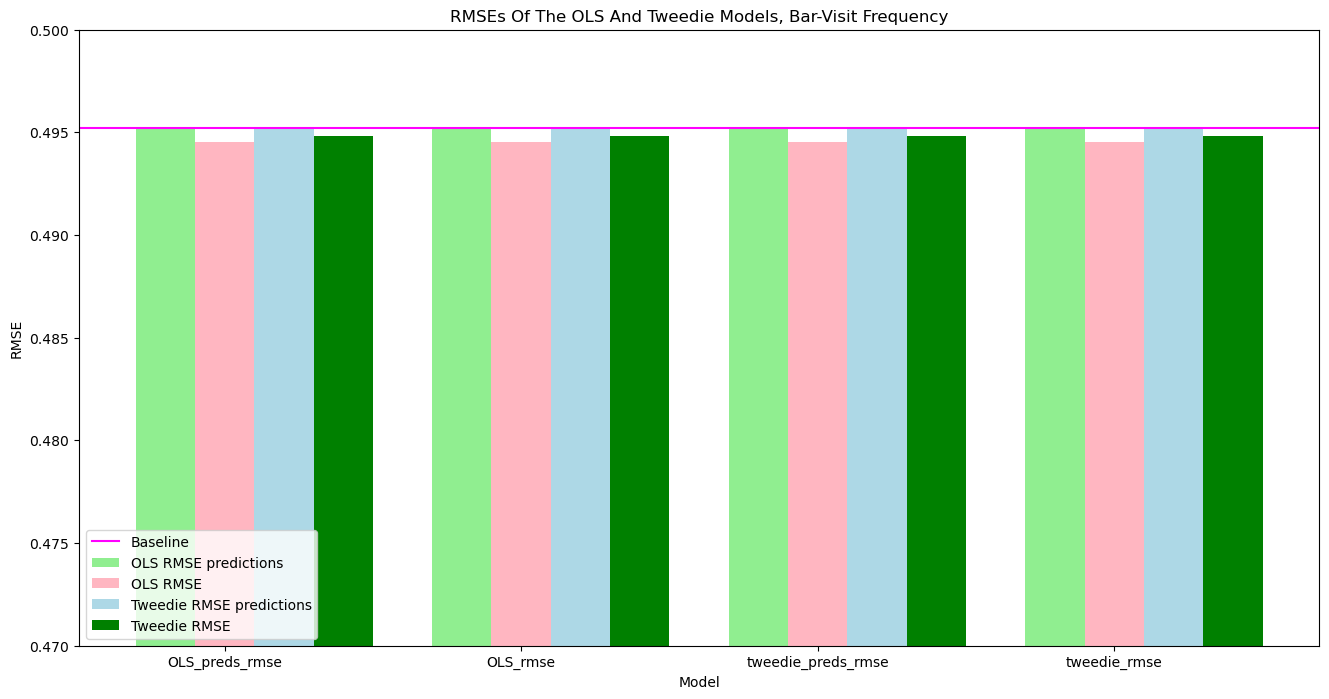

In [43]:
# plotting RMSEs on train, bar-visit frequency

c.plot_all_bar_RMSE(rmse_train_mean, OLS_preds_rmse, OLS_rmse, tweedie_preds_rmse, tweedie_rmse)

**_OVERALL TAKEAWAYS_ for the train dataset in regards to bar-visit frequency and accepting the coupon : The OLS model was slightly better than the Tweedie model.**

**Moving forward, the OLS model will be run on validate.**

&nbsp;

### Object Of Least Squares (OLS), Validate Dataset, Bar-Visit Frequency

In [44]:
# OLS RMSE for weather and coupon

OLS_preds_rmse, OLS_rmse = c.coupon_ols(val, 'bar_freq')

The RMSE on the baseline against accepting the coupon is 0.4945.
The RMSE for the OLS Linear Regression model was 0.4943.


### Tweedie Regressor, Validate Dataset, Bar-Visit Frequency

In [45]:
# Tweedie RMSE for weather and coupon

tweedie_preds_rmse, tweedie_rmse = c.coupon_tweed(val, X_val, y_val, 'bar_freq', 'Y')

The RMSE on the baseline of weather against coupon acceptance is 0.4945.
The RMSE for the Tweedie Regressor model was 0.4944.


In [46]:
bar_val_df = c.bar_rmse_val_df(y_val, rmse_val_mean, OLS_preds_rmse, 
                               OLS_rmse, tweedie_preds_rmse, tweedie_rmse)

bar_val_df.head(1)

,actual_y,baseline,OLS_preds_RMSE,OLS_RMSE,Tweedie_preds_RMSE,Tweedie_RMSE
0,0,0.4946,0.4945,0.4943,0.4945,0.4944


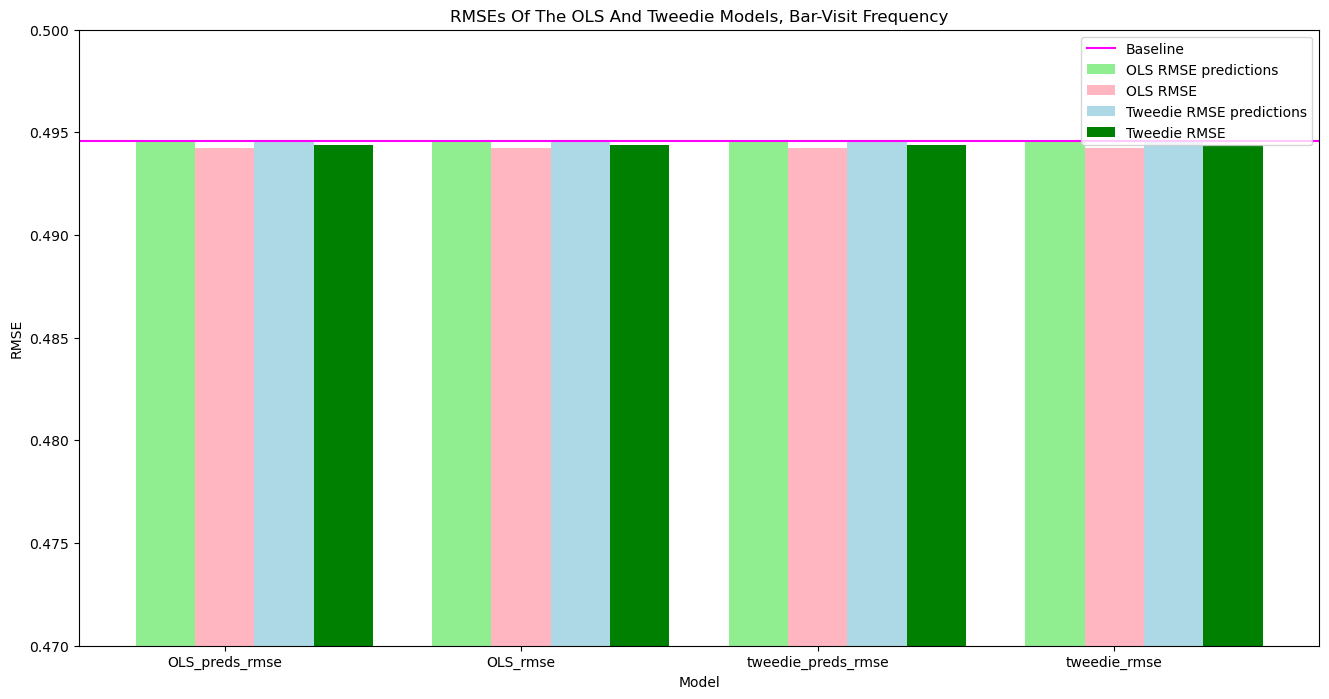

In [47]:
# plotting RMSEs on validate, bar-visit frequency

c.plot_all_bar_RMSE(rmse_val_mean, OLS_preds_rmse, OLS_rmse, tweedie_preds_rmse, tweedie_rmse)

**_OVERALL TAKEAWAYS, VALIDATE, BAR VISITS_ : The OLS model for the monthly frequency of bar visits outperforms both the baseline and the Tweedie Regressor model.** 

&nbsp;

### Object Of Least Squares (OLS), Test Dataset, Bar-Visit Frequency

In [48]:
# OLS RMSE for weather and coupon

OLS_preds_rmse, OLS_rmse = c.coupon_ols(test, 'bar_freq')

The RMSE on the baseline against accepting the coupon is 0.4962.
The RMSE for the OLS Linear Regression model was 0.4959.


In [49]:
# test df for bar-visit frequency

bar_test_df = c.bar_rmse_test_df(y_test, rmse_test_mean, OLS_preds_rmse, OLS_rmse)

bar_test_df.head(1)

,actual_y,baseline,OLS_preds_RMSE,OLS_RMSE
0,1,0.4962,0.4962,0.4959


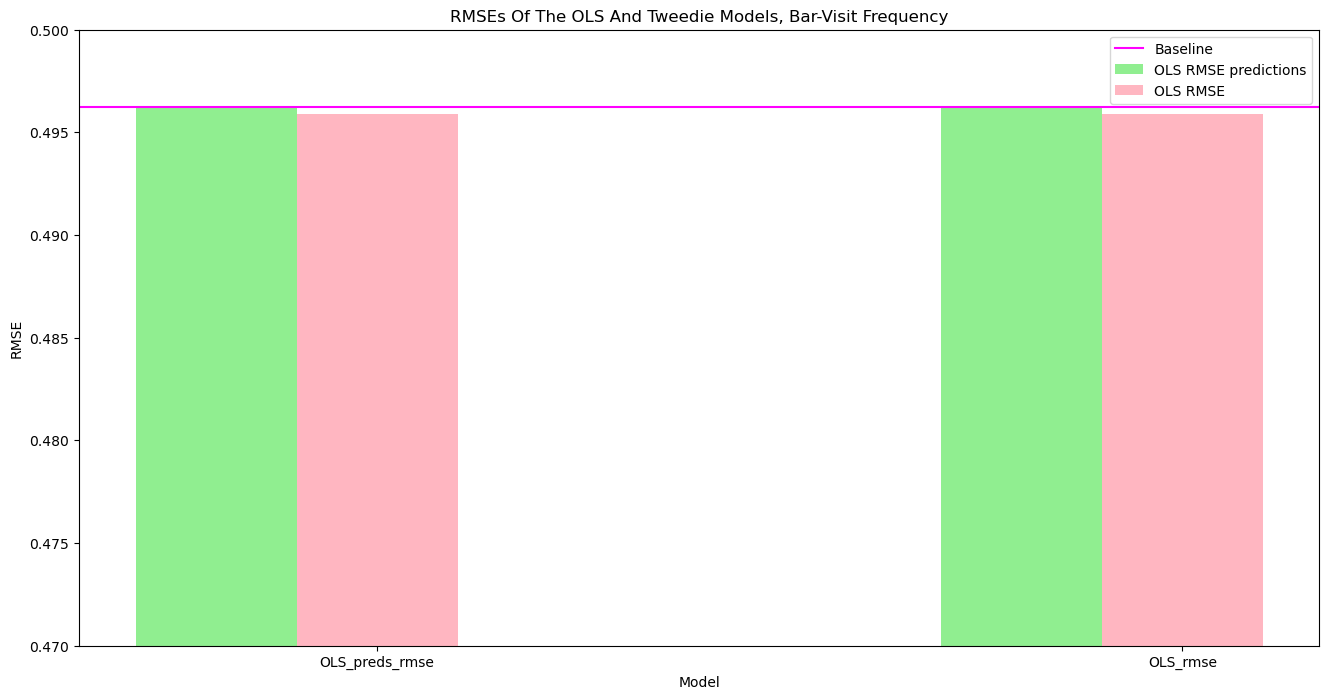

In [50]:
# plotting RMSEs on validate, bar-visit frequency

c.plot_test_bar_RMSE(rmse_test_mean, OLS_preds_rmse, OLS_rmse)

**REGRESSION MODELLING TAKEAWAYS : The OLS model is more accurate than the baseline.**

<h1 style="background-color:#7bccc4;"></br><center>Modelling : Classification</br></h1>

<h3 style="background-color:#c7e9c0;"></br><center> Decision Tree & Random Forest, 3 Branches, Train Dataset</br></h3>

In [51]:
# max depth 3
clf3, random = c.random_decision3(rmse_train_mean, X_train, y_train, 'Y')

The baseline of about 0.4952 indicates the likelihood that a vehicle driver will accept the coupon.

Decision Tree Accuracy, max depth of 3 : 0.589

Random Forest Accuracy, max depth of 3 : 0.5933


In [52]:
# classification report, train, 3 branches, DT

c.classif_rpt_train(clf3, X_train, y_train)

Classification Report For Training Dataset 
  
               precision    recall  f1-score   support

           0       0.55      0.27      0.36      3795
           1       0.60      0.83      0.70      5008

    accuracy                           0.59      8803
   macro avg       0.57      0.55      0.53      8803
weighted avg       0.58      0.59      0.55      8803



In [53]:
# classification report, train, 3 branches, RF

c.classif_rpt_train(random, X_train, y_train)

Classification Report For Training Dataset 
  
               precision    recall  f1-score   support

           0       0.59      0.19      0.29      3795
           1       0.59      0.90      0.72      5008

    accuracy                           0.59      8803
   macro avg       0.59      0.54      0.50      8803
weighted avg       0.59      0.59      0.53      8803



**TAKEAWAY : The Decision Tree with 3 branches is a tad more accurate (by 0.0043) than the Random Forest with 3 branches. The 3-branch Decision Tree is much more accurate than the baseline (0.4952), by 0.0938, or about 9.38pc.**

<h3 style="background-color:#c7e9c0;"></br><center> Decision Tree & Random Forest, 7 Branches, Train Dataset</br></h3>

In [54]:
# random forest, decision tree, 7

clf7, random7 = c.random_decision_7(rmse_train_mean, X_train, y_train, 'Y')

The baseline of about 0.4952 indicates the likelihood that a vehicle driver will accept the coupon.

Decision Tree Accuracy, max depth of 7 : 0.6113

Random Forest Accuracy, max depth of 7 : 0.6038


In [55]:
# classification report, train, 7 branches, DT


c.classif_rpt_train(clf7, X_train, y_train)

Classification Report For Training Dataset 
  
               precision    recall  f1-score   support

           0       0.59      0.33      0.42      3795
           1       0.62      0.83      0.71      5008

    accuracy                           0.61      8803
   macro avg       0.60      0.58      0.56      8803
weighted avg       0.61      0.61      0.58      8803



In [56]:
# classification report, train, 7 branches, RF

c.classif_rpt_train(random7, X_train, y_train)

Classification Report For Training Dataset 
  
               precision    recall  f1-score   support

           0       0.60      0.24      0.34      3795
           1       0.60      0.88      0.72      5008

    accuracy                           0.60      8803
   macro avg       0.60      0.56      0.53      8803
weighted avg       0.60      0.60      0.55      8803



**TAKEAWAY : The Decision Tree with 7 branches is a tad more accurate (by 0.0075) than the Random Forest with 7 branches. The 7-branch Decision Tree is, likewise, more accurate than the baseline (0.4952), by 0.1161, or about 11.61pc.**

&nbsp;

<h3 style="background-color:#c7e9c0;"></br><center> Decision Tree & Random Forest, 3 Branches, Validate Dataset</br></h3>

In [57]:
# max depth 3
clf3, random = c.random_decision3(rmse_val_mean, X_val, y_val, 'Y')

The baseline of about 0.4946 indicates the likelihood that a vehicle driver will accept the coupon.

Decision Tree Accuracy, max depth of 3 : 0.5866

Random Forest Accuracy, max depth of 3 : 0.5769


In [58]:
# classification report, val, 3 branches, DT

c.classif_rpt_val(clf3, X_val, y_val)

Classification Report For Validate Dataset 
  
               precision    recall  f1-score   support

           0       0.56      0.15      0.23       965
           1       0.59      0.91      0.72      1299

    accuracy                           0.59      2264
   macro avg       0.57      0.53      0.47      2264
weighted avg       0.58      0.59      0.51      2264



In [59]:
# classification report, val, 3 branches, RF

c.classif_rpt_val(random, X_val, y_val)

Classification Report For Validate Dataset 
  
               precision    recall  f1-score   support

           0       0.63      0.02      0.03       965
           1       0.58      0.99      0.73      1299

    accuracy                           0.58      2264
   macro avg       0.60      0.50      0.38      2264
weighted avg       0.60      0.58      0.43      2264



**TAKEAWAY : The Decision Tree with 3 branches is a tad more accurate (by 0.0043) than the Random Forest with 3 branches on the validate dataset. The 3-branch Decision Tree is much more accurate than the baseline (0.4946), by 0.092, or about 9.2pc.**

<h3 style="background-color:#c7e9c0;"></br><center> Decision Tree & Random Forest, 7 Branches, Validate Dataset</br></h3>

In [60]:
# random forest, decision tree, 7

clf7, random7 = c.random_decision_7(rmse_val_mean, X_val, y_val, 'Y')

The baseline of about 0.4946 indicates the likelihood that a vehicle driver will accept the coupon.

Decision Tree Accuracy, max depth of 7 : 0.6246

Random Forest Accuracy, max depth of 7 : 0.6144


In [61]:
# classification report, val, 7 branches, DT

c.classif_rpt_test(clf7, X_val, y_val)

Classification Report For Test Dataset 
  
               precision    recall  f1-score   support

           0       0.59      0.39      0.47       965
           1       0.64      0.80      0.71      1299

    accuracy                           0.62      2264
   macro avg       0.61      0.59      0.59      2264
weighted avg       0.62      0.62      0.61      2264



In [62]:
# classification report, val, 7 branches, RF

c.classif_rpt_test(random7, X_val, y_val)

Classification Report For Test Dataset 
  
               precision    recall  f1-score   support

           0       0.67      0.19      0.29       965
           1       0.61      0.93      0.74      1299

    accuracy                           0.61      2264
   macro avg       0.64      0.56      0.51      2264
weighted avg       0.63      0.61      0.55      2264



**TAKEAWAY : The Decision Tree with 7 branches (accuracy 0.6246) is a more accurate (by 0.0102) than the Random Forest with 7 branches on the validate dataset. The 7-branch Decision Tree is, likewise, more accurate than the baseline (0.4946), by 0.13, or about 13pc.**  

**Going forward, because the Decision Tree has been the most accurate on both the train and validate datasets, it will be put to the test dataset.**


&nbsp;

<h3 style="background-color:#c7e9c0;"></br><center> Decision Tree & Random Forest, 7 Branches, Test Dataset</br></h3>

In [63]:
# 3 branches

clf3 = c.decision3(rmse_test_mean, X_test, y_test, 'Y')

The baseline of about 0.4962 indicates the likelihood that a vehicle driver will accept the coupon.

Decision Tree Accuracy, max depth of 3 : 0.6053


In [64]:
# 7 branches

clf7 = c.decision_7(rmse_test_mean, X_test, y_test, 'Y')

The baseline of about 0.4962 indicates the likelihood that a vehicle driver will accept the coupon.

Decision Tree Accuracy, max depth of 7 : 0.6649


**Classification Report For Test Dataset, 3 Branches, Decision Tree**

In [65]:
# classification report, test, 3 branches

c.classif_rpt_test(clf3, X_test, y_test)

Classification Report For Test Dataset 
  
               precision    recall  f1-score   support

           0       0.63      0.25      0.35       662
           1       0.60      0.88      0.72       848

    accuracy                           0.61      1510
   macro avg       0.61      0.57      0.54      1510
weighted avg       0.61      0.61      0.56      1510



**Classification Report For Test Dataset, 7 Branches, Decision Tree**

In [66]:
# classification report, test, 7 branches

c.classif_rpt_test(clf7, X_test, y_test)

Classification Report For Test Dataset 
  
               precision    recall  f1-score   support

           0       0.67      0.47      0.55       662
           1       0.66      0.82      0.73       848

    accuracy                           0.66      1510
   macro avg       0.67      0.64      0.64      1510
weighted avg       0.67      0.66      0.65      1510



**CLASSIFICATION TAKEAWAYS : After running the Decision Tree with a max depth of 3 and with a max depth of 7 on the test dataset, it was shown that the max depth of 7 continues to be superior in accuracy, with an accuracy of 0.6649, compared to the max depth 3 Decision Tree's accuracy of 0.6053.**   

**The Decision Tree with a max depth of 7 also beats the baseline by 0.1687 or about 16.87pc. These results show increasing accuracy without overfitting.**

&nbsp;

<h1 style="background-color:#7bccc4;"></br><center>Recommendations, Next Steps & Conclusion</br></h1>

**RECOMMENDATION : Prefer classification models for this dataset in its current format of discrete variables.**

**NEXT STEPS : Combine features such as weather & income group, or how frequently the driver visits a coffee house & education level, to explore how they relate to the target variable.**

**CONCLUSION : Surprising factors influence a driver's decision to accept time-limited coupons. It is worth exploring more, with different features being addressed. Based on outcomes and applications, this could be a successful marketing technique, to both local residents and tourists.**